In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import cudf as pd
import cupy as np
from sklearn.model_selection import cross_val_score
import numpy

## Importing the data

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal,250000


In [4]:
len(train_df.columns)

81

## Data Cleaning

In [5]:
train_df.shape

(1460, 81)

In [6]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64
 5   Street         1460 non-null   object
 6   Alley          91 non-null     object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64
 18  OverallCond    1460 non-null   

## Filling Missing Values

In [7]:
train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].median(), inplace=True)
train_df['BsmtFinType1'].fillna('Unknown', inplace=True)
train_df['BsmtFinType2'].fillna('Unknown', inplace=True)

In [8]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64
 5   Street         1460 non-null   object
 6   Alley          91 non-null     object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64
 18  OverallCond    1460 non-null   

In [9]:
test_df.shape

(1459, 80)

In [10]:
test_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1459 non-null   int64
 1   MSSubClass     1459 non-null   int64
 2   MSZoning       1455 non-null   object
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64
 5   Street         1459 non-null   object
 6   Alley          107 non-null    object
 7   LotShape       1459 non-null   object
 8   LandContour    1459 non-null   object
 9   Utilities      1457 non-null   object
 10  LotConfig      1459 non-null   object
 11  LandSlope      1459 non-null   object
 12  Neighborhood   1459 non-null   object
 13  Condition1     1459 non-null   object
 14  Condition2     1459 non-null   object
 15  BldgType       1459 non-null   object
 16  HouseStyle     1459 non-null   object
 17  OverallQual    1459 non-null   int64
 18  OverallCond    1459 non-null   

In [11]:
test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].median(), inplace=True)
test_df['BsmtFinType1'].fillna('Unknown', inplace=True)
test_df['BsmtFinSF1'].fillna(test_df['BsmtFinSF1'].median(), inplace=True)
test_df['BsmtFinType2'].fillna('Unknown', inplace=True)
test_df['BsmtFinSF2'].fillna(test_df['BsmtFinSF2'].median(), inplace=True)
test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].median(), inplace=True)
test_df['GarageArea'].fillna(test_df['GarageArea'].median(), inplace = True)

In [12]:
test_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1459 non-null   int64
 1   MSSubClass     1459 non-null   int64
 2   MSZoning       1455 non-null   object
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64
 5   Street         1459 non-null   object
 6   Alley          107 non-null    object
 7   LotShape       1459 non-null   object
 8   LandContour    1459 non-null   object
 9   Utilities      1457 non-null   object
 10  LotConfig      1459 non-null   object
 11  LandSlope      1459 non-null   object
 12  Neighborhood   1459 non-null   object
 13  Condition1     1459 non-null   object
 14  Condition2     1459 non-null   object
 15  BldgType       1459 non-null   object
 16  HouseStyle     1459 non-null   object
 17  OverallQual    1459 non-null   int64
 18  OverallCond    1459 non-null   

In [13]:
x_data = train_df.iloc[:,:-1]

## Selecting the required columns

In [14]:
x_data = x_data[['LotArea', 'OverallQual', 'OverallCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','1stFlrSF','2ndFlrSF', 'GrLivArea', 'MasVnrArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'FullBath','GarageArea']]

## Encoding the categorical features using one hot encoding

In [15]:
x_data = pd.get_dummies(x_data)

In [16]:
y_data = train_df.iloc[:,-1]

## Model Training

In [17]:
from cuml.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, train_size=0.8)

In [18]:
from cuml.linear_model import LinearRegression
lr_eig = LinearRegression(fit_intercept = True, normalize = False, algorithm = "eig")
lr_svd = LinearRegression(fit_intercept = True, normalize = False, algorithm = "svd")
lr_qr = LinearRegression(fit_intercept = True, normalize = False, algorithm = "qr")
lr_svdqr = LinearRegression(fit_intercept = True, normalize = False, algorithm = "svd-qr")
lr_svdjac = LinearRegression(fit_intercept = True, normalize = False, algorithm = "svd-jacobi")

In [19]:
lr_eig.fit(x_train, y_train)
lr_svd.fit(x_train, y_train)
lr_qr.fit(x_train, y_train)
lr_svdqr.fit(x_train, y_train)
lr_svdjac.fit(x_train, y_train)

LinearRegression()

In [20]:
preds_eig = lr_eig.predict(x_val)
preds_svd = lr_svd.predict(x_val)
preds_qr = lr_qr.predict(x_val)
preds_svdqr = lr_svdqr.predict(x_val)
preds_svdjac = lr_svdjac.predict(x_val)

In [21]:
preds_eig = preds_eig.astype(np.int64)
preds_svd = preds_svd.astype(np.int64)
preds_qr = preds_qr.astype(np.int64)
preds_svdqr = preds_svdqr.astype(np.int64)
preds_svdjac = preds_svdjac.astype(np.int64)

In [22]:
algos = ['eig','svd','qr','svdqr','svdjacob']

## Model Evaluation

In [23]:
from cuml.metrics.regression import mean_absolute_error
mae = numpy.empty(shape=[5])
mae[0]=(mean_absolute_error(y_val, preds_eig))
mae[1]=(mean_absolute_error(y_val, preds_svd))
mae[2]=(mean_absolute_error(y_val, preds_qr))
mae[3]=(mean_absolute_error(y_val, preds_svdqr))
mae[4]=(mean_absolute_error(y_val, preds_svdjac))
print(mae)

[24603.24657534 24603.24657534 24697.02739726 24603.24657534
 24603.24657534]


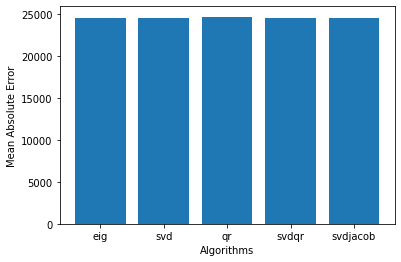

In [24]:
import matplotlib.pyplot as plt
plt.bar(numpy.array(algos),mae)
plt.xlabel('Algorithms')
plt.ylabel('Mean Absolute Error')
plt.show()

In [25]:
from cuml.metrics.regression import mean_squared_error
mse = numpy.empty(shape=[5])
mse[0]=(mean_squared_error(y_val, preds_eig))
mse[1]=(mean_squared_error(y_val, preds_svd))
mse[2]=(mean_squared_error(y_val, preds_qr))
mse[3]=(mean_squared_error(y_val, preds_svdqr))
mse[4]=(mean_squared_error(y_val, preds_svdjac))
print(mse)

[1.41555661e+09 1.41555661e+09 1.42136919e+09 1.41555661e+09
 1.41555661e+09]


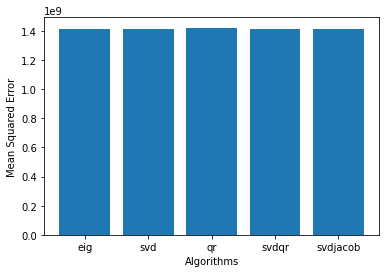

In [26]:
import matplotlib.pyplot as plt
plt.bar(numpy.array(algos),mse)
plt.xlabel('Algorithms')
plt.ylabel('Mean Squared Error')
plt.show()

In [27]:
y_val = y_val.astype(np.float64)
preds_eig = preds_eig.astype(np.float64)
preds_svd = preds_svd.astype(np.float64)
preds_qr = preds_qr.astype(np.float64)
preds_svdqr = preds_svdqr.astype(np.float64)
preds_svdjac = preds_svdjac.astype(np.float64)

In [28]:
from cuml.metrics.regression import r2_score
r2 = numpy.empty(shape=[5])
r2[0]=(r2_score(y_val, preds_eig))
r2[1]=(r2_score(y_val, preds_svd))
r2[2]=(r2_score(y_val, preds_qr))
r2[3]=(r2_score(y_val, preds_svdqr))
r2[4]=(r2_score(y_val, preds_svdjac))
print(r2)

[0.79469115 0.79469115 0.79384811 0.79469115 0.79469115]


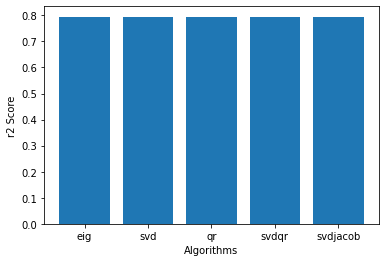

In [29]:
import matplotlib.pyplot as plt
plt.bar(numpy.array(algos),r2)
plt.xlabel('Algorithms')
plt.ylabel('r2 Score')
plt.show()

## Submitting the Results to the Competition

In [30]:
test_df = test_df[['LotArea', 'OverallQual', 'OverallCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','1stFlrSF','2ndFlrSF', 'GrLivArea', 'MasVnrArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath','GarageArea']]

In [31]:
test_df = pd.get_dummies(test_df)

In [32]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [33]:
lr_final = LinearRegression(fit_intercept = True, normalize = False, algorithm = "eig")
lr_final.fit(x_data, y_data)

LinearRegression()

In [34]:
submission['SalePrice'] = lr_final.predict(test_df)

In [35]:
submission.to_csv("submission.csv", index=False)